In [1]:
path = '/home/jupyter/fashion200k_ms'

In [2]:
"""Main method to train the model."""
import argparse
import sys
import time
import datasets
import img_text_composition_models
import numpy as np
!pip install tensorboard 
!pip install tensorboardX --no-cache-dir
from tensorboardX import SummaryWriter
import test_retrieval
import torch
import torch.utils.data
import torchvision
from tqdm import tqdm as tqdm

torch.set_num_threads(3)


In [3]:
path


'/home/jupyter/fashion200k_ms'

### Setup main param

In [4]:

def parse_opt():
  """Parses the input arguments."""
  parser = argparse.ArgumentParser()
  parser.add_argument('-f', type=str, default='')
  parser.add_argument('--comment', type=str, default='test_notebook')
  parser.add_argument('--dataset', type=str, default='fashion200k')
  parser.add_argument(
      '--dataset_path', type=str, default='/home/jupyter/fashion200k_ms')
  parser.add_argument('--model', type=str, default='concat')
  parser.add_argument('--embed_dim', type=int, default=512)
  parser.add_argument('--learning_rate', type=float, default=1e-2)
  parser.add_argument(
      '--learning_rate_decay_frequency', type=int, default=9999999)
  parser.add_argument('--batch_size', type=int, default=32)
  parser.add_argument('--weight_decay', type=float, default=1e-6)
  parser.add_argument('--num_iters', type=int, default=150000)
  parser.add_argument('--loss', type=str, default='batch_based_classification')
  parser.add_argument('--loader_num_workers', type=int, default=4)
  args = parser.parse_args()
  return args




### Prepare the Dataset

In [5]:

def load_dataset(opt):
  """Loads the input datasets."""
  print('Reading dataset ', opt.dataset)
  if opt.dataset == 'fashion200k':
    trainset = datasets.Fashion200k(
        path=opt.dataset_path,
        split='train',
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(224),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))
    testset = datasets.Fashion200k(
        path=opt.dataset_path,
        split='test',
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(224),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))
  else:
    print('Invalid dataset', opt.dataset) 
    sys.exit()

  print('trainset size:', len(trainset)) 
  print('testset size:', len(testset)) 
  return trainset, testset



### Create the Model and Optimizer

In [6]:
def create_model_and_optimizer(opt, texts):
  """Builds the model and related optimizer."""
  
  print('Creating model and optimizer for', opt.model) 
  if opt.model == 'concat':
    model = img_text_composition_models.Concat(texts, embed_dim=opt.embed_dim)
  else:
    print('Invalid model', opt.model) 
    sys.exit()
  model = model.cuda()

  # create optimizer
  params = []
  # low learning rate for pretrained layers on real image datasets
 
  params.append({
        'params': [p for p in model.img_model.fc.parameters()],
        'lr': opt.learning_rate
    })
  params.append({
        'params': [p for p in model.img_model.parameters()],
        'lr': 0.1 * opt.learning_rate
    })
  
  params.append({'params': [p for p in model.parameters()]})
  for _, p1 in enumerate(params):  # remove duplicated params
    for _, p2 in enumerate(params):
      if p1 is not p2:
        for p11 in p1['params']:
          for j, p22 in enumerate(p2['params']):
            if p11 is p22:
              p2['params'][j] = torch.tensor(0.0, requires_grad=True)
  
  optimizer = torch.optim.SGD(
      params, lr=opt.learning_rate, momentum=0.9, weight_decay=opt.weight_decay)
  
  return model, optimizer


### Training Loops

In [7]:

def train_loop(opt, logger, trainset, testset, model, optimizer):
  """Function for train loop"""

  print('Begin training')
  losses_tracking = {}
  it = 0
  epoch = -1
  tic = time.time()
  
  while it < opt.num_iters:
    epoch += 1

    # show/log stats
    print('It', it, 'epoch', epoch, 'Elapsed time', round(time.time() - tic,4), opt.comment)

    tic = time.time()
    for loss_name in losses_tracking:
      avg_loss = np.mean(losses_tracking[loss_name][-len(trainloader):])
      print('    Loss', loss_name, round(avg_loss, 4))

      logger.add_scalar(loss_name, avg_loss, it)
    logger.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], it)

    # test
    if epoch % 3 == 1:
      tests = []
      for name, dataset in [('train', trainset), ('test', testset)]:
        t = test_retrieval.test(opt, model, dataset)
        tests += [(name + ' ' + metric_name, metric_value)
                  for metric_name, metric_value in t]
      for metric_name, metric_value in tests:
        logger.add_scalar(metric_name, metric_value, it)
        print('    ', metric_name, round(metric_value, 4))

    # save checkpoint
    torch.save({
        'it': it,
        'opt': opt,
        'model_state_dict': model.state_dict(),
    },
               logger.file_writer.get_logdir() + '/latest_checkpoint.pth')
    
    

    # run trainning for 1 epoch
    model.train()
    trainloader = trainset.get_loader(
        batch_size=opt.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=opt.loader_num_workers)


    def training_1_iter(data):
      assert type(data) is list
      img1 = np.stack([d['source_img_data'] for d in data])
      img1 = torch.from_numpy(img1).float()
      img1 = torch.autograd.Variable(img1).cuda()
      img2 = np.stack([d['target_img_data'] for d in data])
      img2 = torch.from_numpy(img2).float()
      img2 = torch.autograd.Variable(img2).cuda()
      mods = [str(d['mod']['str']) for d in data]
      mods = [t for t in mods]

      # compute loss
      losses = []
      if opt.loss == 'soft_triplet':
        loss_value = model.compute_loss(
            img1, mods, img2, soft_triplet_loss=True)
      elif opt.loss == 'batch_based_classification':
        loss_value = model.compute_loss(
            img1, mods, img2, soft_triplet_loss=False)
      else:
        print('Invalid loss function', opt.loss)
        sys.exit()
      loss_name = opt.loss
      loss_weight = 1.0
      losses += [(loss_name, loss_weight, loss_value)]
      total_loss = sum([
          loss_weight * loss_value
          for loss_name, loss_weight, loss_value in losses
      ])
      assert not torch.isnan(total_loss)
      losses += [('total training loss', None, total_loss)]

      # track losses
      for loss_name, loss_weight, loss_value in losses:
        if not loss_name in losses_tracking:
          losses_tracking[loss_name] = []
        losses_tracking[loss_name].append(float(loss_value))

      # gradient descend
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

    for data in tqdm(trainloader, desc='Training for epoch ' + str(epoch)):
      it += 1
      training_1_iter(data)
      #print('num_iters is  ',it,'epoch  is  ',epoch)

      # decay learing rate
      if it >= opt.learning_rate_decay_frequency and it % opt.learning_rate_decay_frequency == 0:
        for g in optimizer.param_groups:
          g['lr'] *= 0.1

    ### Final Results
    if it >opt.num_iters:
      tests = []
      for name, dataset in [('train', trainset), ('test', testset)]:
        t = test_retrieval.test(opt, model, dataset)
        tests += [(name + ' ' + metric_name, metric_value)
                  for metric_name, metric_value in t]
      for metric_name, metric_value in tests:
        logger.add_scalar(metric_name, metric_value, it)
        print('    ', metric_name, round(metric_value, 4))

  print('num_iters is  ',it,'epoch  is  ',epoch)
  print('Finished training')


### Main Training

In [8]:
opt = parse_opt()
print('opt:     ',opt)
print('Arguments:')
    
for k in opt.__dict__.keys():
  print('    ', k, ':', str(opt.__dict__[k]))
        
    

opt:      Namespace(batch_size=32, comment='test_notebook', dataset='fashion200k', dataset_path='/home/jupyter/fashion200k_ms', embed_dim=512, f='/home/jupyter/.local/share/jupyter/runtime/kernel-0f5c9dd1-6441-446f-9419-b96bcd6b1683.json', learning_rate=0.01, learning_rate_decay_frequency=9999999, loader_num_workers=4, loss='batch_based_classification', model='concat', num_iters=150000, weight_decay=1e-06)
Arguments:
     f : /home/jupyter/.local/share/jupyter/runtime/kernel-0f5c9dd1-6441-446f-9419-b96bcd6b1683.json
     comment : test_notebook
     dataset : fashion200k
     dataset_path : /home/jupyter/fashion200k_ms
     model : concat
     embed_dim : 512
     learning_rate : 0.01
     learning_rate_decay_frequency : 9999999
     batch_size : 32
     weight_decay : 1e-06
     num_iters : 150000
     loss : batch_based_classification
     loader_num_workers : 4


In [9]:
logger = SummaryWriter(comment=opt.comment)
print('Log files saved to', logger.file_writer.get_logdir())
for k in opt.__dict__.keys():
  logger.add_text(k, str(opt.__dict__[k]))


trainset, testset = load_dataset(opt)
model, optimizer = create_model_and_optimizer(opt, [t for t in trainset.get_all_texts()])

train_loop(opt, logger, trainset, testset, model, optimizer)

logger.close()


Log files saved to runs/Apr07_01-11-39_my-fastai-instance-nopretest_notebook
Reading dataset  fashion200k
read pants_train_detect_all.txt
Fashion200k: 26301 images
9264 unique captions
Modifiable images 14681
read pants_test_detect_all.txt
Fashion200k: 5343 images
trainset size: 26301
testset size: 5343
Creating model and optimizer for concat


Training for epoch 0:   0%|          | 0/821 [00:00<?, ?it/s]

Begin training
It 0 epoch 0 Elapsed time 0.0 test_notebook


Training for epoch 0: 100%|██████████| 821/821 [01:42<00:00,  8.00it/s]


It 821 epoch 1 Elapsed time 102.6713 test_notebook
    Loss batch_based_classification 2.1222
    Loss total training loss 2.1222


Training for epoch 1:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.0743
     train recall_top5_correct_composition 0.156
     train recall_top10_correct_composition 0.2101
     train recall_top50_correct_composition 0.4083
     train recall_top100_correct_composition 0.5182
     test recall_top1_correct_composition 0.0258
     test recall_top5_correct_composition 0.0664
     test recall_top10_correct_composition 0.1303
     test recall_top50_correct_composition 0.3814
     test recall_top100_correct_composition 0.5076


Training for epoch 2:   0%|          | 0/821 [00:00<?, ?it/s]

It 1642 epoch 2 Elapsed time 202.0538 test_notebook
    Loss batch_based_classification 1.3211
    Loss total training loss 1.3211


Training for epoch 3:   0%|          | 0/821 [00:00<?, ?it/s]

It 2463 epoch 3 Elapsed time 102.8922 test_notebook
    Loss batch_based_classification 0.9127
    Loss total training loss 0.9127


Training for epoch 3: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 3284 epoch 4 Elapsed time 102.9214 test_notebook
    Loss batch_based_classification 0.6902
    Loss total training loss 0.6902


Training for epoch 4:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.235
     train recall_top5_correct_composition 0.4108
     train recall_top10_correct_composition 0.5158
     train recall_top50_correct_composition 0.7621
     train recall_top100_correct_composition 0.8474
     test recall_top1_correct_composition 0.0572
     test recall_top5_correct_composition 0.1306
     test recall_top10_correct_composition 0.186
     test recall_top50_correct_composition 0.409
     test recall_top100_correct_composition 0.5585


Training for epoch 5:   0%|          | 0/821 [00:00<?, ?it/s]

It 4105 epoch 5 Elapsed time 201.3067 test_notebook
    Loss batch_based_classification 0.6038
    Loss total training loss 0.6038


Training for epoch 6:   0%|          | 0/821 [00:00<?, ?it/s]

It 4926 epoch 6 Elapsed time 102.926 test_notebook
    Loss batch_based_classification 0.4714
    Loss total training loss 0.4714


Training for epoch 6: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 5747 epoch 7 Elapsed time 102.8973 test_notebook
    Loss batch_based_classification 0.3873
    Loss total training loss 0.3873


Training for epoch 7:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.3011
     train recall_top5_correct_composition 0.5225
     train recall_top10_correct_composition 0.6424
     train recall_top50_correct_composition 0.8665
     train recall_top100_correct_composition 0.9234
     test recall_top1_correct_composition 0.0445
     test recall_top5_correct_composition 0.1749
     test recall_top10_correct_composition 0.243
     test recall_top50_correct_composition 0.46
     test recall_top100_correct_composition 0.5908


Training for epoch 8:   0%|          | 0/821 [00:00<?, ?it/s]

It 6568 epoch 8 Elapsed time 201.6481 test_notebook
    Loss batch_based_classification 0.3643
    Loss total training loss 0.3643


Training for epoch 9:   0%|          | 0/821 [00:00<?, ?it/s]

It 7389 epoch 9 Elapsed time 102.879 test_notebook
    Loss batch_based_classification 0.3022
    Loss total training loss 0.3022


Training for epoch 9: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 8210 epoch 10 Elapsed time 102.8384 test_notebook
    Loss batch_based_classification 0.2671
    Loss total training loss 0.2671


Training for epoch 10:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.3827
     train recall_top5_correct_composition 0.6171
     train recall_top10_correct_composition 0.7297
     train recall_top50_correct_composition 0.9239
     train recall_top100_correct_composition 0.9616
     test recall_top1_correct_composition 0.0786
     test recall_top5_correct_composition 0.1568
     test recall_top10_correct_composition 0.259
     test recall_top50_correct_composition 0.545
     test recall_top100_correct_composition 0.6651


Training for epoch 11:   0%|          | 0/821 [00:00<?, ?it/s]

It 9031 epoch 11 Elapsed time 201.3274 test_notebook
    Loss batch_based_classification 0.2486
    Loss total training loss 0.2486


Training for epoch 12:   0%|          | 0/821 [00:00<?, ?it/s]

It 9852 epoch 12 Elapsed time 102.863 test_notebook
    Loss batch_based_classification 0.212
    Loss total training loss 0.212


Training for epoch 12: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 10673 epoch 13 Elapsed time 102.8364 test_notebook
    Loss batch_based_classification 0.1854
    Loss total training loss 0.1854


Training for epoch 13:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.412
     train recall_top5_correct_composition 0.6547
     train recall_top10_correct_composition 0.7644
     train recall_top50_correct_composition 0.9447
     train recall_top100_correct_composition 0.9777
     test recall_top1_correct_composition 0.0635
     test recall_top5_correct_composition 0.1738
     test recall_top10_correct_composition 0.2467
     test recall_top50_correct_composition 0.474
     test recall_top100_correct_composition 0.6096


Training for epoch 14:   0%|          | 0/821 [00:00<?, ?it/s]

It 11494 epoch 14 Elapsed time 201.1202 test_notebook
    Loss batch_based_classification 0.1813
    Loss total training loss 0.1813


Training for epoch 15:   0%|          | 0/821 [00:00<?, ?it/s]

It 12315 epoch 15 Elapsed time 102.8086 test_notebook
    Loss batch_based_classification 0.1665
    Loss total training loss 0.1665


Training for epoch 15: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 13136 epoch 16 Elapsed time 102.8663 test_notebook
    Loss batch_based_classification 0.1514
    Loss total training loss 0.1514


Training for epoch 16:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.4804
     train recall_top5_correct_composition 0.7154
     train recall_top10_correct_composition 0.823
     train recall_top50_correct_composition 0.9631
     train recall_top100_correct_composition 0.9854
     test recall_top1_correct_composition 0.0686
     test recall_top5_correct_composition 0.1668
     test recall_top10_correct_composition 0.2299
     test recall_top50_correct_composition 0.4834
     test recall_top100_correct_composition 0.5919


Training for epoch 17:   0%|          | 0/821 [00:00<?, ?it/s]

It 13957 epoch 17 Elapsed time 202.5804 test_notebook
    Loss batch_based_classification 0.1548
    Loss total training loss 0.1548


Training for epoch 18:   0%|          | 0/821 [00:00<?, ?it/s]

It 14778 epoch 18 Elapsed time 103.0552 test_notebook
    Loss batch_based_classification 0.1272
    Loss total training loss 0.1272


Training for epoch 18: 100%|██████████| 821/821 [01:43<00:00,  7.97it/s]


It 15599 epoch 19 Elapsed time 103.0962 test_notebook
    Loss batch_based_classification 0.1166
    Loss total training loss 0.1166


Training for epoch 19:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.5009
     train recall_top5_correct_composition 0.7544
     train recall_top10_correct_composition 0.8556
     train recall_top50_correct_composition 0.9744
     train recall_top100_correct_composition 0.9906
     test recall_top1_correct_composition 0.0611
     test recall_top5_correct_composition 0.129
     test recall_top10_correct_composition 0.1904
     test recall_top50_correct_composition 0.476
     test recall_top100_correct_composition 0.6201


Training for epoch 20:   0%|          | 0/821 [00:00<?, ?it/s]

It 16420 epoch 20 Elapsed time 203.9554 test_notebook
    Loss batch_based_classification 0.1208
    Loss total training loss 0.1208


Training for epoch 21:   0%|          | 0/821 [00:00<?, ?it/s]

It 17241 epoch 21 Elapsed time 102.9187 test_notebook
    Loss batch_based_classification 0.1019
    Loss total training loss 0.1019


Training for epoch 21: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 18062 epoch 22 Elapsed time 103.0414 test_notebook
    Loss batch_based_classification 0.1032
    Loss total training loss 0.1032


Training for epoch 22:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.5417
     train recall_top5_correct_composition 0.7824
     train recall_top10_correct_composition 0.8773
     train recall_top50_correct_composition 0.9816
     train recall_top100_correct_composition 0.9928
     test recall_top1_correct_composition 0.0799
     test recall_top5_correct_composition 0.2061
     test recall_top10_correct_composition 0.2993
     test recall_top50_correct_composition 0.5175
     test recall_top100_correct_composition 0.6513


Training for epoch 23:   0%|          | 0/821 [00:00<?, ?it/s]

It 18883 epoch 23 Elapsed time 203.8275 test_notebook
    Loss batch_based_classification 0.1081
    Loss total training loss 0.1081


Training for epoch 24:   0%|          | 0/821 [00:00<?, ?it/s]

It 19704 epoch 24 Elapsed time 102.9633 test_notebook
    Loss batch_based_classification 0.0911
    Loss total training loss 0.0911


Training for epoch 24: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 20525 epoch 25 Elapsed time 102.9745 test_notebook
    Loss batch_based_classification 0.09
    Loss total training loss 0.09


Training for epoch 25:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.5722
     train recall_top5_correct_composition 0.809
     train recall_top10_correct_composition 0.8996
     train recall_top50_correct_composition 0.9874
     train recall_top100_correct_composition 0.9968
     test recall_top1_correct_composition 0.0585
     test recall_top5_correct_composition 0.1642
     test recall_top10_correct_composition 0.2181
     test recall_top50_correct_composition 0.5013
     test recall_top100_correct_composition 0.6354


Training for epoch 26:   0%|          | 0/821 [00:00<?, ?it/s]

It 21346 epoch 26 Elapsed time 202.0442 test_notebook
    Loss batch_based_classification 0.0917
    Loss total training loss 0.0917


Training for epoch 27:   0%|          | 0/821 [00:00<?, ?it/s]

It 22167 epoch 27 Elapsed time 102.8763 test_notebook
    Loss batch_based_classification 0.0817
    Loss total training loss 0.0817


Training for epoch 27: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 22988 epoch 28 Elapsed time 102.9387 test_notebook
    Loss batch_based_classification 0.0742
    Loss total training loss 0.0742


Training for epoch 28:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.5947
     train recall_top5_correct_composition 0.8352
     train recall_top10_correct_composition 0.9131
     train recall_top50_correct_composition 0.9882
     train recall_top100_correct_composition 0.9967
     test recall_top1_correct_composition 0.0771
     test recall_top5_correct_composition 0.1775
     test recall_top10_correct_composition 0.2697
     test recall_top50_correct_composition 0.5365
     test recall_top100_correct_composition 0.6393


Training for epoch 29:   0%|          | 0/821 [00:00<?, ?it/s]

It 23809 epoch 29 Elapsed time 202.0509 test_notebook
    Loss batch_based_classification 0.0829
    Loss total training loss 0.0829


Training for epoch 30:   0%|          | 0/821 [00:00<?, ?it/s]

It 24630 epoch 30 Elapsed time 102.7914 test_notebook
    Loss batch_based_classification 0.0723
    Loss total training loss 0.0723


Training for epoch 30: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 25451 epoch 31 Elapsed time 102.8804 test_notebook
    Loss batch_based_classification 0.0664
    Loss total training loss 0.0664


Training for epoch 31:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.6243
     train recall_top5_correct_composition 0.8442
     train recall_top10_correct_composition 0.9191
     train recall_top50_correct_composition 0.9912
     train recall_top100_correct_composition 0.9975
     test recall_top1_correct_composition 0.0838
     test recall_top5_correct_composition 0.2341
     test recall_top10_correct_composition 0.2954
     test recall_top50_correct_composition 0.5456
     test recall_top100_correct_composition 0.6465


Training for epoch 32:   0%|          | 0/821 [00:00<?, ?it/s]

It 26272 epoch 32 Elapsed time 201.5579 test_notebook
    Loss batch_based_classification 0.0711
    Loss total training loss 0.0711


Training for epoch 33:   0%|          | 0/821 [00:00<?, ?it/s]

It 27093 epoch 33 Elapsed time 102.8473 test_notebook
    Loss batch_based_classification 0.0678
    Loss total training loss 0.0678


Training for epoch 33: 100%|██████████| 821/821 [01:42<00:00,  8.00it/s]


It 27914 epoch 34 Elapsed time 102.7276 test_notebook
    Loss batch_based_classification 0.0621
    Loss total training loss 0.0621


Training for epoch 34:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.6328
     train recall_top5_correct_composition 0.8601
     train recall_top10_correct_composition 0.9324
     train recall_top50_correct_composition 0.9937
     train recall_top100_correct_composition 0.9985
     test recall_top1_correct_composition 0.0655
     test recall_top5_correct_composition 0.1797
     test recall_top10_correct_composition 0.2581
     test recall_top50_correct_composition 0.5175
     test recall_top100_correct_composition 0.659


Training for epoch 35:   0%|          | 0/821 [00:00<?, ?it/s]

It 28735 epoch 35 Elapsed time 201.4332 test_notebook
    Loss batch_based_classification 0.0641
    Loss total training loss 0.0641


Training for epoch 36:   0%|          | 0/821 [00:00<?, ?it/s]

It 29556 epoch 36 Elapsed time 102.9416 test_notebook
    Loss batch_based_classification 0.0576
    Loss total training loss 0.0576


Training for epoch 36: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 30377 epoch 37 Elapsed time 102.9256 test_notebook
    Loss batch_based_classification 0.0588
    Loss total training loss 0.0588


Training for epoch 37:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.6657
     train recall_top5_correct_composition 0.8815
     train recall_top10_correct_composition 0.9432
     train recall_top50_correct_composition 0.9937
     train recall_top100_correct_composition 0.9985
     test recall_top1_correct_composition 0.0766
     test recall_top5_correct_composition 0.2131
     test recall_top10_correct_composition 0.2943
     test recall_top50_correct_composition 0.5218
     test recall_top100_correct_composition 0.6356


Training for epoch 38:   0%|          | 0/821 [00:00<?, ?it/s]

It 31198 epoch 38 Elapsed time 202.1709 test_notebook
    Loss batch_based_classification 0.0591
    Loss total training loss 0.0591


Training for epoch 39:   0%|          | 0/821 [00:00<?, ?it/s]

It 32019 epoch 39 Elapsed time 102.8901 test_notebook
    Loss batch_based_classification 0.0579
    Loss total training loss 0.0579


Training for epoch 39: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 32840 epoch 40 Elapsed time 102.8397 test_notebook
    Loss batch_based_classification 0.0535
    Loss total training loss 0.0535


Training for epoch 40:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.6666
     train recall_top5_correct_composition 0.8741
     train recall_top10_correct_composition 0.9422
     train recall_top50_correct_composition 0.9955
     train recall_top100_correct_composition 0.9989
     test recall_top1_correct_composition 0.067
     test recall_top5_correct_composition 0.1666
     test recall_top10_correct_composition 0.2714
     test recall_top50_correct_composition 0.5138
     test recall_top100_correct_composition 0.6561


Training for epoch 41:   0%|          | 0/821 [00:00<?, ?it/s]

It 33661 epoch 41 Elapsed time 201.0933 test_notebook
    Loss batch_based_classification 0.0573
    Loss total training loss 0.0573


Training for epoch 42:   0%|          | 0/821 [00:00<?, ?it/s]

It 34482 epoch 42 Elapsed time 102.8939 test_notebook
    Loss batch_based_classification 0.0505
    Loss total training loss 0.0505


Training for epoch 42: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 35303 epoch 43 Elapsed time 102.8753 test_notebook
    Loss batch_based_classification 0.0501
    Loss total training loss 0.0501


Training for epoch 43:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.6787
     train recall_top5_correct_composition 0.8856
     train recall_top10_correct_composition 0.9511
     train recall_top50_correct_composition 0.9962
     train recall_top100_correct_composition 0.999
     test recall_top1_correct_composition 0.0515
     test recall_top5_correct_composition 0.1391
     test recall_top10_correct_composition 0.2255
     test recall_top50_correct_composition 0.5242
     test recall_top100_correct_composition 0.6638


Training for epoch 44:   0%|          | 0/821 [00:00<?, ?it/s]

It 36124 epoch 44 Elapsed time 201.64 test_notebook
    Loss batch_based_classification 0.0517
    Loss total training loss 0.0517


Training for epoch 45:   0%|          | 0/821 [00:00<?, ?it/s]

It 36945 epoch 45 Elapsed time 102.8417 test_notebook
    Loss batch_based_classification 0.048
    Loss total training loss 0.048


Training for epoch 45: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 37766 epoch 46 Elapsed time 102.7796 test_notebook
    Loss batch_based_classification 0.045
    Loss total training loss 0.045


Training for epoch 46:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.6823
     train recall_top5_correct_composition 0.8939
     train recall_top10_correct_composition 0.9521
     train recall_top50_correct_composition 0.9966
     train recall_top100_correct_composition 0.9994
     test recall_top1_correct_composition 0.0712
     test recall_top5_correct_composition 0.1969
     test recall_top10_correct_composition 0.2585
     test recall_top50_correct_composition 0.5205
     test recall_top100_correct_composition 0.6448


Training for epoch 47:   0%|          | 0/821 [00:00<?, ?it/s]

It 38587 epoch 47 Elapsed time 201.783 test_notebook
    Loss batch_based_classification 0.0499
    Loss total training loss 0.0499


Training for epoch 48:   0%|          | 0/821 [00:00<?, ?it/s]

It 39408 epoch 48 Elapsed time 102.8329 test_notebook
    Loss batch_based_classification 0.0469
    Loss total training loss 0.0469


Training for epoch 48: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 40229 epoch 49 Elapsed time 102.8617 test_notebook
    Loss batch_based_classification 0.0477
    Loss total training loss 0.0477


Training for epoch 49:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7056
     train recall_top5_correct_composition 0.9048
     train recall_top10_correct_composition 0.9597
     train recall_top50_correct_composition 0.997
     train recall_top100_correct_composition 0.9995
     test recall_top1_correct_composition 0.0509
     test recall_top5_correct_composition 0.1817
     test recall_top10_correct_composition 0.2596
     test recall_top50_correct_composition 0.5277
     test recall_top100_correct_composition 0.6694


Training for epoch 50:   0%|          | 0/821 [00:00<?, ?it/s]

It 41050 epoch 50 Elapsed time 202.2517 test_notebook
    Loss batch_based_classification 0.0469
    Loss total training loss 0.0469


Training for epoch 51:   0%|          | 0/821 [00:00<?, ?it/s]

It 41871 epoch 51 Elapsed time 102.8818 test_notebook
    Loss batch_based_classification 0.0443
    Loss total training loss 0.0443


Training for epoch 51: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 42692 epoch 52 Elapsed time 102.9702 test_notebook
    Loss batch_based_classification 0.0437
    Loss total training loss 0.0437


Training for epoch 52:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7054
     train recall_top5_correct_composition 0.9024
     train recall_top10_correct_composition 0.9613
     train recall_top50_correct_composition 0.9979
     train recall_top100_correct_composition 0.9999
     test recall_top1_correct_composition 0.0642
     test recall_top5_correct_composition 0.1865
     test recall_top10_correct_composition 0.2884
     test recall_top50_correct_composition 0.5552
     test recall_top100_correct_composition 0.6541


Training for epoch 53:   0%|          | 0/821 [00:00<?, ?it/s]

It 43513 epoch 53 Elapsed time 202.065 test_notebook
    Loss batch_based_classification 0.0441
    Loss total training loss 0.0441


Training for epoch 54:   0%|          | 0/821 [00:00<?, ?it/s]

It 44334 epoch 54 Elapsed time 102.8449 test_notebook
    Loss batch_based_classification 0.041
    Loss total training loss 0.041


Training for epoch 54: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 45155 epoch 55 Elapsed time 102.9147 test_notebook
    Loss batch_based_classification 0.0404
    Loss total training loss 0.0404


Training for epoch 55:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7202
     train recall_top5_correct_composition 0.9066
     train recall_top10_correct_composition 0.9603
     train recall_top50_correct_composition 0.9973
     train recall_top100_correct_composition 0.9995
     test recall_top1_correct_composition 0.0598
     test recall_top5_correct_composition 0.1736
     test recall_top10_correct_composition 0.288
     test recall_top50_correct_composition 0.5559
     test recall_top100_correct_composition 0.6528


Training for epoch 56:   0%|          | 0/821 [00:00<?, ?it/s]

It 45976 epoch 56 Elapsed time 202.0626 test_notebook
    Loss batch_based_classification 0.0392
    Loss total training loss 0.0392


Training for epoch 57:   0%|          | 0/821 [00:00<?, ?it/s]

It 46797 epoch 57 Elapsed time 102.9207 test_notebook
    Loss batch_based_classification 0.0424
    Loss total training loss 0.0424


Training for epoch 57: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 47618 epoch 58 Elapsed time 102.9072 test_notebook
    Loss batch_based_classification 0.0373
    Loss total training loss 0.0373


Training for epoch 58:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7256
     train recall_top5_correct_composition 0.9114
     train recall_top10_correct_composition 0.9644
     train recall_top50_correct_composition 0.9974
     train recall_top100_correct_composition 0.9995
     test recall_top1_correct_composition 0.0624
     test recall_top5_correct_composition 0.193
     test recall_top10_correct_composition 0.2666
     test recall_top50_correct_composition 0.5293
     test recall_top100_correct_composition 0.6454


Training for epoch 59:   0%|          | 0/821 [00:00<?, ?it/s]

It 48439 epoch 59 Elapsed time 202.4345 test_notebook
    Loss batch_based_classification 0.0403
    Loss total training loss 0.0403


Training for epoch 60:   0%|          | 0/821 [00:00<?, ?it/s]

It 49260 epoch 60 Elapsed time 102.9572 test_notebook
    Loss batch_based_classification 0.0384
    Loss total training loss 0.0384


Training for epoch 60: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 50081 epoch 61 Elapsed time 102.9555 test_notebook
    Loss batch_based_classification 0.0333
    Loss total training loss 0.0333


Training for epoch 61:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7571
     train recall_top5_correct_composition 0.9253
     train recall_top10_correct_composition 0.9727
     train recall_top50_correct_composition 0.9991
     train recall_top100_correct_composition 0.9999
     test recall_top1_correct_composition 0.0782
     test recall_top5_correct_composition 0.1766
     test recall_top10_correct_composition 0.2415
     test recall_top50_correct_composition 0.4843
     test recall_top100_correct_composition 0.6439


Training for epoch 62:   0%|          | 0/821 [00:00<?, ?it/s]

It 50902 epoch 62 Elapsed time 202.5184 test_notebook
    Loss batch_based_classification 0.0393
    Loss total training loss 0.0393


Training for epoch 63:   0%|          | 0/821 [00:00<?, ?it/s]

It 51723 epoch 63 Elapsed time 102.8825 test_notebook
    Loss batch_based_classification 0.0361
    Loss total training loss 0.0361


Training for epoch 63: 100%|██████████| 821/821 [01:43<00:00,  7.97it/s]


It 52544 epoch 64 Elapsed time 103.1004 test_notebook
    Loss batch_based_classification 0.0339
    Loss total training loss 0.0339


Training for epoch 64:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7513
     train recall_top5_correct_composition 0.9289
     train recall_top10_correct_composition 0.9716
     train recall_top50_correct_composition 0.9986
     train recall_top100_correct_composition 0.9997
     test recall_top1_correct_composition 0.0563
     test recall_top5_correct_composition 0.1607
     test recall_top10_correct_composition 0.2579
     test recall_top50_correct_composition 0.5085
     test recall_top100_correct_composition 0.6393


Training for epoch 65:   0%|          | 0/821 [00:00<?, ?it/s]

It 53365 epoch 65 Elapsed time 202.1317 test_notebook
    Loss batch_based_classification 0.0352
    Loss total training loss 0.0352


Training for epoch 66:   0%|          | 0/821 [00:00<?, ?it/s]

It 54186 epoch 66 Elapsed time 102.8422 test_notebook
    Loss batch_based_classification 0.0374
    Loss total training loss 0.0374


Training for epoch 66: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 55007 epoch 67 Elapsed time 102.9508 test_notebook
    Loss batch_based_classification 0.0318
    Loss total training loss 0.0318


Training for epoch 67:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7542
     train recall_top5_correct_composition 0.9291
     train recall_top10_correct_composition 0.9724
     train recall_top50_correct_composition 0.9989
     train recall_top100_correct_composition 0.9997
     test recall_top1_correct_composition 0.064
     test recall_top5_correct_composition 0.2068
     test recall_top10_correct_composition 0.2959
     test recall_top50_correct_composition 0.55
     test recall_top100_correct_composition 0.6924


Training for epoch 68:   0%|          | 0/821 [00:00<?, ?it/s]

It 55828 epoch 68 Elapsed time 202.4724 test_notebook
    Loss batch_based_classification 0.0384
    Loss total training loss 0.0384


Training for epoch 69:   0%|          | 0/821 [00:00<?, ?it/s]

It 56649 epoch 69 Elapsed time 102.9004 test_notebook
    Loss batch_based_classification 0.0338
    Loss total training loss 0.0338


Training for epoch 69: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 57470 epoch 70 Elapsed time 102.8771 test_notebook
    Loss batch_based_classification 0.0354
    Loss total training loss 0.0354


Training for epoch 70:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7515
     train recall_top5_correct_composition 0.9316
     train recall_top10_correct_composition 0.9722
     train recall_top50_correct_composition 0.9985
     train recall_top100_correct_composition 0.9998
     test recall_top1_correct_composition 0.0753
     test recall_top5_correct_composition 0.1683
     test recall_top10_correct_composition 0.2393
     test recall_top50_correct_composition 0.5269
     test recall_top100_correct_composition 0.6303


Training for epoch 71:   0%|          | 0/821 [00:00<?, ?it/s]

It 58291 epoch 71 Elapsed time 201.5717 test_notebook
    Loss batch_based_classification 0.0338
    Loss total training loss 0.0338


Training for epoch 72:   0%|          | 0/821 [00:00<?, ?it/s]

It 59112 epoch 72 Elapsed time 102.8557 test_notebook
    Loss batch_based_classification 0.0297
    Loss total training loss 0.0297


Training for epoch 72: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 59933 epoch 73 Elapsed time 102.8647 test_notebook
    Loss batch_based_classification 0.0331
    Loss total training loss 0.0331


Training for epoch 73:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7518
     train recall_top5_correct_composition 0.9213
     train recall_top10_correct_composition 0.9681
     train recall_top50_correct_composition 0.9983
     train recall_top100_correct_composition 0.9995
     test recall_top1_correct_composition 0.05
     test recall_top5_correct_composition 0.181
     test recall_top10_correct_composition 0.2432
     test recall_top50_correct_composition 0.4913
     test recall_top100_correct_composition 0.617


Training for epoch 74:   0%|          | 0/821 [00:00<?, ?it/s]

It 60754 epoch 74 Elapsed time 202.2557 test_notebook
    Loss batch_based_classification 0.035
    Loss total training loss 0.035


Training for epoch 75:   0%|          | 0/821 [00:00<?, ?it/s]

It 61575 epoch 75 Elapsed time 102.8433 test_notebook
    Loss batch_based_classification 0.0319
    Loss total training loss 0.0319


Training for epoch 75: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 62396 epoch 76 Elapsed time 102.8571 test_notebook
    Loss batch_based_classification 0.0311
    Loss total training loss 0.0311


Training for epoch 76:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7821
     train recall_top5_correct_composition 0.944
     train recall_top10_correct_composition 0.9824
     train recall_top50_correct_composition 0.9989
     train recall_top100_correct_composition 0.9997
     test recall_top1_correct_composition 0.0677
     test recall_top5_correct_composition 0.1961
     test recall_top10_correct_composition 0.2517
     test recall_top50_correct_composition 0.5255
     test recall_top100_correct_composition 0.6546


Training for epoch 77:   0%|          | 0/821 [00:00<?, ?it/s]

It 63217 epoch 77 Elapsed time 201.6657 test_notebook
    Loss batch_based_classification 0.0305
    Loss total training loss 0.0305


Training for epoch 78:   0%|          | 0/821 [00:00<?, ?it/s]

It 64038 epoch 78 Elapsed time 102.9323 test_notebook
    Loss batch_based_classification 0.0301
    Loss total training loss 0.0301


Training for epoch 78: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 64859 epoch 79 Elapsed time 102.8222 test_notebook
    Loss batch_based_classification 0.029
    Loss total training loss 0.029


Training for epoch 79:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7686
     train recall_top5_correct_composition 0.9358
     train recall_top10_correct_composition 0.9779
     train recall_top50_correct_composition 0.9981
     train recall_top100_correct_composition 0.9994
     test recall_top1_correct_composition 0.0688
     test recall_top5_correct_composition 0.1832
     test recall_top10_correct_composition 0.2563
     test recall_top50_correct_composition 0.5127
     test recall_top100_correct_composition 0.6467


Training for epoch 80:   0%|          | 0/821 [00:00<?, ?it/s]

It 65680 epoch 80 Elapsed time 202.0644 test_notebook
    Loss batch_based_classification 0.0306
    Loss total training loss 0.0306


Training for epoch 81:   0%|          | 0/821 [00:00<?, ?it/s]

It 66501 epoch 81 Elapsed time 102.8457 test_notebook
    Loss batch_based_classification 0.0292
    Loss total training loss 0.0292


Training for epoch 81: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 67322 epoch 82 Elapsed time 102.8347 test_notebook
    Loss batch_based_classification 0.0292
    Loss total training loss 0.0292


Training for epoch 82:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7842
     train recall_top5_correct_composition 0.9427
     train recall_top10_correct_composition 0.9814
     train recall_top50_correct_composition 0.9998
     train recall_top100_correct_composition 0.9999
     test recall_top1_correct_composition 0.0692
     test recall_top5_correct_composition 0.1646
     test recall_top10_correct_composition 0.2428
     test recall_top50_correct_composition 0.4681
     test recall_top100_correct_composition 0.614


Training for epoch 83:   0%|          | 0/821 [00:00<?, ?it/s]

It 68143 epoch 83 Elapsed time 202.1224 test_notebook
    Loss batch_based_classification 0.0276
    Loss total training loss 0.0276


Training for epoch 84:   0%|          | 0/821 [00:00<?, ?it/s]

It 68964 epoch 84 Elapsed time 102.9415 test_notebook
    Loss batch_based_classification 0.0272
    Loss total training loss 0.0272


Training for epoch 84: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 69785 epoch 85 Elapsed time 102.8289 test_notebook
    Loss batch_based_classification 0.0275
    Loss total training loss 0.0275


Training for epoch 85:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.804
     train recall_top5_correct_composition 0.9491
     train recall_top10_correct_composition 0.9829
     train recall_top50_correct_composition 0.9997
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0747
     test recall_top5_correct_composition 0.207
     test recall_top10_correct_composition 0.298
     test recall_top50_correct_composition 0.5456
     test recall_top100_correct_composition 0.6773


Training for epoch 86:   0%|          | 0/821 [00:00<?, ?it/s]

It 70606 epoch 86 Elapsed time 201.5469 test_notebook
    Loss batch_based_classification 0.0283
    Loss total training loss 0.0283


Training for epoch 87:   0%|          | 0/821 [00:00<?, ?it/s]

It 71427 epoch 87 Elapsed time 102.9415 test_notebook
    Loss batch_based_classification 0.0281
    Loss total training loss 0.0281


Training for epoch 87: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 72248 epoch 88 Elapsed time 102.9161 test_notebook
    Loss batch_based_classification 0.0277
    Loss total training loss 0.0277


Training for epoch 88:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7968
     train recall_top5_correct_composition 0.9489
     train recall_top10_correct_composition 0.984
     train recall_top50_correct_composition 0.9997
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.06
     test recall_top5_correct_composition 0.1762
     test recall_top10_correct_composition 0.2546
     test recall_top50_correct_composition 0.5138
     test recall_top100_correct_composition 0.6504


Training for epoch 89:   0%|          | 0/821 [00:00<?, ?it/s]

It 73069 epoch 89 Elapsed time 201.7909 test_notebook
    Loss batch_based_classification 0.0224
    Loss total training loss 0.0224


Training for epoch 90:   0%|          | 0/821 [00:00<?, ?it/s]

It 73890 epoch 90 Elapsed time 102.7732 test_notebook
    Loss batch_based_classification 0.0267
    Loss total training loss 0.0267


Training for epoch 90: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 74711 epoch 91 Elapsed time 102.8801 test_notebook
    Loss batch_based_classification 0.0268
    Loss total training loss 0.0268


Training for epoch 91:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.7965
     train recall_top5_correct_composition 0.9515
     train recall_top10_correct_composition 0.9833
     train recall_top50_correct_composition 0.9997
     train recall_top100_correct_composition 0.9999
     test recall_top1_correct_composition 0.0734
     test recall_top5_correct_composition 0.1662
     test recall_top10_correct_composition 0.2821
     test recall_top50_correct_composition 0.5079
     test recall_top100_correct_composition 0.6448


Training for epoch 92:   0%|          | 0/821 [00:00<?, ?it/s]

It 75532 epoch 92 Elapsed time 201.4982 test_notebook
    Loss batch_based_classification 0.0275
    Loss total training loss 0.0275


Training for epoch 93:   0%|          | 0/821 [00:00<?, ?it/s]

It 76353 epoch 93 Elapsed time 102.8488 test_notebook
    Loss batch_based_classification 0.0268
    Loss total training loss 0.0268


Training for epoch 93: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 77174 epoch 94 Elapsed time 102.8067 test_notebook
    Loss batch_based_classification 0.0288
    Loss total training loss 0.0288


Training for epoch 94:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8096
     train recall_top5_correct_composition 0.956
     train recall_top10_correct_composition 0.9857
     train recall_top50_correct_composition 0.9996
     train recall_top100_correct_composition 0.9998
     test recall_top1_correct_composition 0.0869
     test recall_top5_correct_composition 0.2092
     test recall_top10_correct_composition 0.2886
     test recall_top50_correct_composition 0.5122
     test recall_top100_correct_composition 0.6391


Training for epoch 95:   0%|          | 0/821 [00:00<?, ?it/s]

It 77995 epoch 95 Elapsed time 201.7837 test_notebook
    Loss batch_based_classification 0.0275
    Loss total training loss 0.0275


Training for epoch 96:   0%|          | 0/821 [00:00<?, ?it/s]

It 78816 epoch 96 Elapsed time 102.8868 test_notebook
    Loss batch_based_classification 0.0243
    Loss total training loss 0.0243


Training for epoch 96: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 79637 epoch 97 Elapsed time 102.8486 test_notebook
    Loss batch_based_classification 0.0227
    Loss total training loss 0.0227


Training for epoch 97:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8254
     train recall_top5_correct_composition 0.9604
     train recall_top10_correct_composition 0.9887
     train recall_top50_correct_composition 0.9992
     train recall_top100_correct_composition 0.9999
     test recall_top1_correct_composition 0.083
     test recall_top5_correct_composition 0.1889
     test recall_top10_correct_composition 0.2924
     test recall_top50_correct_composition 0.519
     test recall_top100_correct_composition 0.6539


Training for epoch 98:   0%|          | 0/821 [00:00<?, ?it/s]

It 80458 epoch 98 Elapsed time 201.1448 test_notebook
    Loss batch_based_classification 0.0232
    Loss total training loss 0.0232


Training for epoch 99:   0%|          | 0/821 [00:00<?, ?it/s]

It 81279 epoch 99 Elapsed time 102.918 test_notebook
    Loss batch_based_classification 0.026
    Loss total training loss 0.026


Training for epoch 99: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 82100 epoch 100 Elapsed time 102.7954 test_notebook
    Loss batch_based_classification 0.0236
    Loss total training loss 0.0236


Training for epoch 100:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8033
     train recall_top5_correct_composition 0.9506
     train recall_top10_correct_composition 0.9855
     train recall_top50_correct_composition 0.9997
     train recall_top100_correct_composition 0.9998
     test recall_top1_correct_composition 0.0631
     test recall_top5_correct_composition 0.1793
     test recall_top10_correct_composition 0.2773
     test recall_top50_correct_composition 0.4998
     test recall_top100_correct_composition 0.6373


Training for epoch 101:   0%|          | 0/821 [00:00<?, ?it/s]

It 82921 epoch 101 Elapsed time 201.3936 test_notebook
    Loss batch_based_classification 0.0239
    Loss total training loss 0.0239


Training for epoch 102:   0%|          | 0/821 [00:00<?, ?it/s]

It 83742 epoch 102 Elapsed time 102.8861 test_notebook
    Loss batch_based_classification 0.0267
    Loss total training loss 0.0267


Training for epoch 102: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 84563 epoch 103 Elapsed time 102.8515 test_notebook
    Loss batch_based_classification 0.0259
    Loss total training loss 0.0259


Training for epoch 103:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8174
     train recall_top5_correct_composition 0.9582
     train recall_top10_correct_composition 0.9869
     train recall_top50_correct_composition 0.9998
     train recall_top100_correct_composition 0.9999
     test recall_top1_correct_composition 0.0817
     test recall_top5_correct_composition 0.2061
     test recall_top10_correct_composition 0.2961
     test recall_top50_correct_composition 0.505
     test recall_top100_correct_composition 0.6454


Training for epoch 104:   0%|          | 0/821 [00:00<?, ?it/s]

It 85384 epoch 104 Elapsed time 201.4614 test_notebook
    Loss batch_based_classification 0.0238
    Loss total training loss 0.0238


Training for epoch 105:   0%|          | 0/821 [00:00<?, ?it/s]

It 86205 epoch 105 Elapsed time 102.8664 test_notebook
    Loss batch_based_classification 0.0242
    Loss total training loss 0.0242


Training for epoch 105: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 87026 epoch 106 Elapsed time 102.8713 test_notebook
    Loss batch_based_classification 0.0214
    Loss total training loss 0.0214


Training for epoch 106:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8217
     train recall_top5_correct_composition 0.9598
     train recall_top10_correct_composition 0.9873
     train recall_top50_correct_composition 0.9997
     train recall_top100_correct_composition 0.9998
     test recall_top1_correct_composition 0.0836
     test recall_top5_correct_composition 0.1983
     test recall_top10_correct_composition 0.2803
     test recall_top50_correct_composition 0.5181
     test recall_top100_correct_composition 0.6373


Training for epoch 107:   0%|          | 0/821 [00:00<?, ?it/s]

It 87847 epoch 107 Elapsed time 201.5939 test_notebook
    Loss batch_based_classification 0.0244
    Loss total training loss 0.0244


Training for epoch 108:   0%|          | 0/821 [00:00<?, ?it/s]

It 88668 epoch 108 Elapsed time 102.8755 test_notebook
    Loss batch_based_classification 0.0238
    Loss total training loss 0.0238


Training for epoch 108: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 89489 epoch 109 Elapsed time 102.9744 test_notebook
    Loss batch_based_classification 0.0231
    Loss total training loss 0.0231


Training for epoch 109:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8308
     train recall_top5_correct_composition 0.9586
     train recall_top10_correct_composition 0.9883
     train recall_top50_correct_composition 0.9995
     train recall_top100_correct_composition 0.9998
     test recall_top1_correct_composition 0.0631
     test recall_top5_correct_composition 0.1939
     test recall_top10_correct_composition 0.2583
     test recall_top50_correct_composition 0.509
     test recall_top100_correct_composition 0.6439


Training for epoch 110:   0%|          | 0/821 [00:00<?, ?it/s]

It 90310 epoch 110 Elapsed time 201.533 test_notebook
    Loss batch_based_classification 0.0234
    Loss total training loss 0.0234


Training for epoch 111:   0%|          | 0/821 [00:00<?, ?it/s]

It 91131 epoch 111 Elapsed time 102.8777 test_notebook
    Loss batch_based_classification 0.023
    Loss total training loss 0.023


Training for epoch 111: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 91952 epoch 112 Elapsed time 102.8344 test_notebook
    Loss batch_based_classification 0.0238
    Loss total training loss 0.0238


Training for epoch 112:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8348
     train recall_top5_correct_composition 0.9629
     train recall_top10_correct_composition 0.9878
     train recall_top50_correct_composition 0.9999
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.067
     test recall_top5_correct_composition 0.1734
     test recall_top10_correct_composition 0.2563
     test recall_top50_correct_composition 0.5175
     test recall_top100_correct_composition 0.6441


Training for epoch 113:   0%|          | 0/821 [00:00<?, ?it/s]

It 92773 epoch 113 Elapsed time 201.4462 test_notebook
    Loss batch_based_classification 0.0216
    Loss total training loss 0.0216


Training for epoch 114:   0%|          | 0/821 [00:00<?, ?it/s]

It 93594 epoch 114 Elapsed time 102.8708 test_notebook
    Loss batch_based_classification 0.0247
    Loss total training loss 0.0247


Training for epoch 114: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 94415 epoch 115 Elapsed time 102.8743 test_notebook
    Loss batch_based_classification 0.0231
    Loss total training loss 0.0231


Training for epoch 115:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8396
     train recall_top5_correct_composition 0.9678
     train recall_top10_correct_composition 0.9911
     train recall_top50_correct_composition 0.9998
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0681
     test recall_top5_correct_composition 0.1777
     test recall_top10_correct_composition 0.2793
     test recall_top50_correct_composition 0.5197
     test recall_top100_correct_composition 0.6491


Training for epoch 116:   0%|          | 0/821 [00:00<?, ?it/s]

It 95236 epoch 116 Elapsed time 201.5399 test_notebook
    Loss batch_based_classification 0.0224
    Loss total training loss 0.0224


Training for epoch 117:   0%|          | 0/821 [00:00<?, ?it/s]

It 96057 epoch 117 Elapsed time 102.9225 test_notebook
    Loss batch_based_classification 0.0223
    Loss total training loss 0.0223


Training for epoch 117: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 96878 epoch 118 Elapsed time 102.841 test_notebook
    Loss batch_based_classification 0.0202
    Loss total training loss 0.0202


Training for epoch 118:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8442
     train recall_top5_correct_composition 0.9667
     train recall_top10_correct_composition 0.9907
     train recall_top50_correct_composition 0.9999
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0934
     test recall_top5_correct_composition 0.2081
     test recall_top10_correct_composition 0.2701
     test recall_top50_correct_composition 0.5216
     test recall_top100_correct_composition 0.6483


Training for epoch 119:   0%|          | 0/821 [00:00<?, ?it/s]

It 97699 epoch 119 Elapsed time 201.2375 test_notebook
    Loss batch_based_classification 0.0212
    Loss total training loss 0.0212


Training for epoch 120:   0%|          | 0/821 [00:00<?, ?it/s]

It 98520 epoch 120 Elapsed time 102.7441 test_notebook
    Loss batch_based_classification 0.0202
    Loss total training loss 0.0202


Training for epoch 120: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 99341 epoch 121 Elapsed time 102.8618 test_notebook
    Loss batch_based_classification 0.0266
    Loss total training loss 0.0266


Training for epoch 121:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8432
     train recall_top5_correct_composition 0.9639
     train recall_top10_correct_composition 0.9888
     train recall_top50_correct_composition 0.9996
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.114
     test recall_top5_correct_composition 0.2277
     test recall_top10_correct_composition 0.3179
     test recall_top50_correct_composition 0.5314
     test recall_top100_correct_composition 0.6489


Training for epoch 122:   0%|          | 0/821 [00:00<?, ?it/s]

It 100162 epoch 122 Elapsed time 201.8071 test_notebook
    Loss batch_based_classification 0.0207
    Loss total training loss 0.0207


Training for epoch 123:   0%|          | 0/821 [00:00<?, ?it/s]

It 100983 epoch 123 Elapsed time 102.7592 test_notebook
    Loss batch_based_classification 0.0229
    Loss total training loss 0.0229


Training for epoch 123: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 101804 epoch 124 Elapsed time 102.9443 test_notebook
    Loss batch_based_classification 0.0215
    Loss total training loss 0.0215


Training for epoch 124:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8574
     train recall_top5_correct_composition 0.9687
     train recall_top10_correct_composition 0.9915
     train recall_top50_correct_composition 0.9996
     train recall_top100_correct_composition 0.9999
     test recall_top1_correct_composition 0.079
     test recall_top5_correct_composition 0.2096
     test recall_top10_correct_composition 0.2742
     test recall_top50_correct_composition 0.5094
     test recall_top100_correct_composition 0.6317


Training for epoch 125:   0%|          | 0/821 [00:00<?, ?it/s]

It 102625 epoch 125 Elapsed time 201.2209 test_notebook
    Loss batch_based_classification 0.0227
    Loss total training loss 0.0227


Training for epoch 126:   0%|          | 0/821 [00:00<?, ?it/s]

It 103446 epoch 126 Elapsed time 103.2417 test_notebook
    Loss batch_based_classification 0.0188
    Loss total training loss 0.0188


Training for epoch 126: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 104267 epoch 127 Elapsed time 102.9081 test_notebook
    Loss batch_based_classification 0.0224
    Loss total training loss 0.0224


Training for epoch 127:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8542
     train recall_top5_correct_composition 0.9694
     train recall_top10_correct_composition 0.9917
     train recall_top50_correct_composition 0.9998
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0498
     test recall_top5_correct_composition 0.1825
     test recall_top10_correct_composition 0.2651
     test recall_top50_correct_composition 0.5157
     test recall_top100_correct_composition 0.6354


Training for epoch 128:   0%|          | 0/821 [00:00<?, ?it/s]

It 105088 epoch 128 Elapsed time 201.8891 test_notebook
    Loss batch_based_classification 0.0196
    Loss total training loss 0.0196


Training for epoch 129:   0%|          | 0/821 [00:00<?, ?it/s]

It 105909 epoch 129 Elapsed time 102.822 test_notebook
    Loss batch_based_classification 0.0158
    Loss total training loss 0.0158


Training for epoch 129: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 106730 epoch 130 Elapsed time 102.8779 test_notebook
    Loss batch_based_classification 0.0209
    Loss total training loss 0.0209


Training for epoch 130:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8576
     train recall_top5_correct_composition 0.9715
     train recall_top10_correct_composition 0.9912
     train recall_top50_correct_composition 0.9993
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0502
     test recall_top5_correct_composition 0.221
     test recall_top10_correct_composition 0.2937
     test recall_top50_correct_composition 0.5421
     test recall_top100_correct_composition 0.6603


Training for epoch 131:   0%|          | 0/821 [00:00<?, ?it/s]

It 107551 epoch 131 Elapsed time 201.2848 test_notebook
    Loss batch_based_classification 0.02
    Loss total training loss 0.02


Training for epoch 132:   0%|          | 0/821 [00:00<?, ?it/s]

It 108372 epoch 132 Elapsed time 102.8895 test_notebook
    Loss batch_based_classification 0.0195
    Loss total training loss 0.0195


Training for epoch 132: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 109193 epoch 133 Elapsed time 102.9093 test_notebook
    Loss batch_based_classification 0.0199
    Loss total training loss 0.0199


Training for epoch 133:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8451
     train recall_top5_correct_composition 0.9711
     train recall_top10_correct_composition 0.992
     train recall_top50_correct_composition 0.9997
     train recall_top100_correct_composition 0.9998
     test recall_top1_correct_composition 0.0714
     test recall_top5_correct_composition 0.1919
     test recall_top10_correct_composition 0.2806
     test recall_top50_correct_composition 0.5452
     test recall_top100_correct_composition 0.6703


Training for epoch 134:   0%|          | 0/821 [00:00<?, ?it/s]

It 110014 epoch 134 Elapsed time 201.6502 test_notebook
    Loss batch_based_classification 0.0216
    Loss total training loss 0.0216


Training for epoch 135:   0%|          | 0/821 [00:00<?, ?it/s]

It 110835 epoch 135 Elapsed time 102.9972 test_notebook
    Loss batch_based_classification 0.0177
    Loss total training loss 0.0177


Training for epoch 135: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 111656 epoch 136 Elapsed time 102.8624 test_notebook
    Loss batch_based_classification 0.0192
    Loss total training loss 0.0192


Training for epoch 136:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8639
     train recall_top5_correct_composition 0.9725
     train recall_top10_correct_composition 0.9901
     train recall_top50_correct_composition 0.9999
     train recall_top100_correct_composition 0.9999
     test recall_top1_correct_composition 0.0819
     test recall_top5_correct_composition 0.2223
     test recall_top10_correct_composition 0.3135
     test recall_top50_correct_composition 0.5434
     test recall_top100_correct_composition 0.6587


Training for epoch 137:   0%|          | 0/821 [00:00<?, ?it/s]

It 112477 epoch 137 Elapsed time 201.3397 test_notebook
    Loss batch_based_classification 0.0193
    Loss total training loss 0.0193


Training for epoch 138:   0%|          | 0/821 [00:00<?, ?it/s]

It 113298 epoch 138 Elapsed time 102.8176 test_notebook
    Loss batch_based_classification 0.0161
    Loss total training loss 0.0161


Training for epoch 138: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 114119 epoch 139 Elapsed time 102.8539 test_notebook
    Loss batch_based_classification 0.0193
    Loss total training loss 0.0193


Training for epoch 139:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8587
     train recall_top5_correct_composition 0.9739
     train recall_top10_correct_composition 0.9927
     train recall_top50_correct_composition 0.9996
     train recall_top100_correct_composition 0.9998
     test recall_top1_correct_composition 0.0668
     test recall_top5_correct_composition 0.2026
     test recall_top10_correct_composition 0.281
     test recall_top50_correct_composition 0.4998
     test recall_top100_correct_composition 0.6426


Training for epoch 140:   0%|          | 0/821 [00:00<?, ?it/s]

It 114940 epoch 140 Elapsed time 201.2083 test_notebook
    Loss batch_based_classification 0.0177
    Loss total training loss 0.0177


Training for epoch 141:   0%|          | 0/821 [00:00<?, ?it/s]

It 115761 epoch 141 Elapsed time 102.9262 test_notebook
    Loss batch_based_classification 0.0212
    Loss total training loss 0.0212


Training for epoch 141: 100%|██████████| 821/821 [01:42<00:00,  8.00it/s]


It 116582 epoch 142 Elapsed time 102.75 test_notebook
    Loss batch_based_classification 0.0202
    Loss total training loss 0.0202


Training for epoch 142:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8592
     train recall_top5_correct_composition 0.9736
     train recall_top10_correct_composition 0.9914
     train recall_top50_correct_composition 0.9997
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0563
     test recall_top5_correct_composition 0.2124
     test recall_top10_correct_composition 0.2878
     test recall_top50_correct_composition 0.5334
     test recall_top100_correct_composition 0.6402


Training for epoch 143:   0%|          | 0/821 [00:00<?, ?it/s]

It 117403 epoch 143 Elapsed time 201.1471 test_notebook
    Loss batch_based_classification 0.0169
    Loss total training loss 0.0169


Training for epoch 144:   0%|          | 0/821 [00:00<?, ?it/s]

It 118224 epoch 144 Elapsed time 102.8668 test_notebook
    Loss batch_based_classification 0.0195
    Loss total training loss 0.0195


Training for epoch 144: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 119045 epoch 145 Elapsed time 102.8808 test_notebook
    Loss batch_based_classification 0.0196
    Loss total training loss 0.0196


Training for epoch 145:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8693
     train recall_top5_correct_composition 0.9745
     train recall_top10_correct_composition 0.9937
     train recall_top50_correct_composition 0.9997
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0793
     test recall_top5_correct_composition 0.2306
     test recall_top10_correct_composition 0.2878
     test recall_top50_correct_composition 0.5334
     test recall_top100_correct_composition 0.6465


Training for epoch 146:   0%|          | 0/821 [00:00<?, ?it/s]

It 119866 epoch 146 Elapsed time 201.2895 test_notebook
    Loss batch_based_classification 0.0183
    Loss total training loss 0.0183


Training for epoch 147:   0%|          | 0/821 [00:00<?, ?it/s]

It 120687 epoch 147 Elapsed time 103.0813 test_notebook
    Loss batch_based_classification 0.0208
    Loss total training loss 0.0208


Training for epoch 147: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 121508 epoch 148 Elapsed time 102.8252 test_notebook
    Loss batch_based_classification 0.0189
    Loss total training loss 0.0189


Training for epoch 148:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8753
     train recall_top5_correct_composition 0.9766
     train recall_top10_correct_composition 0.9944
     train recall_top50_correct_composition 0.9999
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0856
     test recall_top5_correct_composition 0.2218
     test recall_top10_correct_composition 0.2725
     test recall_top50_correct_composition 0.4862
     test recall_top100_correct_composition 0.6273


Training for epoch 149:   0%|          | 0/821 [00:00<?, ?it/s]

It 122329 epoch 149 Elapsed time 201.4261 test_notebook
    Loss batch_based_classification 0.0163
    Loss total training loss 0.0163


Training for epoch 150:   0%|          | 0/821 [00:00<?, ?it/s]

It 123150 epoch 150 Elapsed time 102.8864 test_notebook
    Loss batch_based_classification 0.0177
    Loss total training loss 0.0177


Training for epoch 150: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 123971 epoch 151 Elapsed time 102.8547 test_notebook
    Loss batch_based_classification 0.0172
    Loss total training loss 0.0172


Training for epoch 151:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8811
     train recall_top5_correct_composition 0.9794
     train recall_top10_correct_composition 0.995
     train recall_top50_correct_composition 1.0
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0777
     test recall_top5_correct_composition 0.2133
     test recall_top10_correct_composition 0.2858
     test recall_top50_correct_composition 0.5234
     test recall_top100_correct_composition 0.6437


Training for epoch 152:   0%|          | 0/821 [00:00<?, ?it/s]

It 124792 epoch 152 Elapsed time 201.4482 test_notebook
    Loss batch_based_classification 0.0196
    Loss total training loss 0.0196


Training for epoch 153:   0%|          | 0/821 [00:00<?, ?it/s]

It 125613 epoch 153 Elapsed time 102.8719 test_notebook
    Loss batch_based_classification 0.0172
    Loss total training loss 0.0172


Training for epoch 153: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 126434 epoch 154 Elapsed time 102.8207 test_notebook
    Loss batch_based_classification 0.0188
    Loss total training loss 0.0188


Training for epoch 154:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8803
     train recall_top5_correct_composition 0.9781
     train recall_top10_correct_composition 0.9944
     train recall_top50_correct_composition 0.9999
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0828
     test recall_top5_correct_composition 0.2129
     test recall_top10_correct_composition 0.2897
     test recall_top50_correct_composition 0.5373
     test recall_top100_correct_composition 0.6559


Training for epoch 155:   0%|          | 0/821 [00:00<?, ?it/s]

It 127255 epoch 155 Elapsed time 201.2067 test_notebook
    Loss batch_based_classification 0.0164
    Loss total training loss 0.0164


Training for epoch 156:   0%|          | 0/821 [00:00<?, ?it/s]

It 128076 epoch 156 Elapsed time 102.8064 test_notebook
    Loss batch_based_classification 0.018
    Loss total training loss 0.018


Training for epoch 156: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 128897 epoch 157 Elapsed time 102.9389 test_notebook
    Loss batch_based_classification 0.0203
    Loss total training loss 0.0203


Training for epoch 157:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8694
     train recall_top5_correct_composition 0.9757
     train recall_top10_correct_composition 0.9934
     train recall_top50_correct_composition 0.9999
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0561
     test recall_top5_correct_composition 0.1797
     test recall_top10_correct_composition 0.2478
     test recall_top50_correct_composition 0.5157
     test recall_top100_correct_composition 0.6397


Training for epoch 158:   0%|          | 0/821 [00:00<?, ?it/s]

It 129718 epoch 158 Elapsed time 201.3295 test_notebook
    Loss batch_based_classification 0.0159
    Loss total training loss 0.0159


Training for epoch 159:   0%|          | 0/821 [00:00<?, ?it/s]

It 130539 epoch 159 Elapsed time 102.8447 test_notebook
    Loss batch_based_classification 0.0175
    Loss total training loss 0.0175


Training for epoch 159: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 131360 epoch 160 Elapsed time 102.9078 test_notebook
    Loss batch_based_classification 0.0172
    Loss total training loss 0.0172


Training for epoch 160:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8808
     train recall_top5_correct_composition 0.9801
     train recall_top10_correct_composition 0.9961
     train recall_top50_correct_composition 1.0
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0948
     test recall_top5_correct_composition 0.2303
     test recall_top10_correct_composition 0.3146
     test recall_top50_correct_composition 0.5592
     test recall_top100_correct_composition 0.676


Training for epoch 161:   0%|          | 0/821 [00:00<?, ?it/s]

It 132181 epoch 161 Elapsed time 201.8665 test_notebook
    Loss batch_based_classification 0.0175
    Loss total training loss 0.0175


Training for epoch 162:   0%|          | 0/821 [00:00<?, ?it/s]

It 133002 epoch 162 Elapsed time 102.8855 test_notebook
    Loss batch_based_classification 0.0176
    Loss total training loss 0.0176


Training for epoch 162: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 133823 epoch 163 Elapsed time 102.9549 test_notebook
    Loss batch_based_classification 0.0164
    Loss total training loss 0.0164


Training for epoch 163:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.88
     train recall_top5_correct_composition 0.9779
     train recall_top10_correct_composition 0.9934
     train recall_top50_correct_composition 1.0
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0915
     test recall_top5_correct_composition 0.2242
     test recall_top10_correct_composition 0.2996
     test recall_top50_correct_composition 0.5397
     test recall_top100_correct_composition 0.662


Training for epoch 164:   0%|          | 0/821 [00:00<?, ?it/s]

It 134644 epoch 164 Elapsed time 201.4916 test_notebook
    Loss batch_based_classification 0.019
    Loss total training loss 0.019


Training for epoch 165:   0%|          | 0/821 [00:00<?, ?it/s]

It 135465 epoch 165 Elapsed time 102.9742 test_notebook
    Loss batch_based_classification 0.0177
    Loss total training loss 0.0177


Training for epoch 165: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 136286 epoch 166 Elapsed time 102.8381 test_notebook
    Loss batch_based_classification 0.0175
    Loss total training loss 0.0175


Training for epoch 166:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8803
     train recall_top5_correct_composition 0.977
     train recall_top10_correct_composition 0.9945
     train recall_top50_correct_composition 1.0
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0817
     test recall_top5_correct_composition 0.2159
     test recall_top10_correct_composition 0.31
     test recall_top50_correct_composition 0.5312
     test recall_top100_correct_composition 0.6672


Training for epoch 167:   0%|          | 0/821 [00:00<?, ?it/s]

It 137107 epoch 167 Elapsed time 201.9259 test_notebook
    Loss batch_based_classification 0.0164
    Loss total training loss 0.0164


Training for epoch 168:   0%|          | 0/821 [00:00<?, ?it/s]

It 137928 epoch 168 Elapsed time 102.8909 test_notebook
    Loss batch_based_classification 0.0182
    Loss total training loss 0.0182


Training for epoch 168: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 138749 epoch 169 Elapsed time 102.8947 test_notebook
    Loss batch_based_classification 0.0179
    Loss total training loss 0.0179


Training for epoch 169:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8867
     train recall_top5_correct_composition 0.9823
     train recall_top10_correct_composition 0.9947
     train recall_top50_correct_composition 0.9996
     train recall_top100_correct_composition 0.9998
     test recall_top1_correct_composition 0.0655
     test recall_top5_correct_composition 0.1934
     test recall_top10_correct_composition 0.2616
     test recall_top50_correct_composition 0.5057
     test recall_top100_correct_composition 0.6439


Training for epoch 170:   0%|          | 0/821 [00:00<?, ?it/s]

It 139570 epoch 170 Elapsed time 201.7241 test_notebook
    Loss batch_based_classification 0.0154
    Loss total training loss 0.0154


Training for epoch 171:   0%|          | 0/821 [00:00<?, ?it/s]

It 140391 epoch 171 Elapsed time 102.8328 test_notebook
    Loss batch_based_classification 0.0184
    Loss total training loss 0.0184


Training for epoch 171: 100%|██████████| 821/821 [01:42<00:00,  7.99it/s]


It 141212 epoch 172 Elapsed time 102.8732 test_notebook
    Loss batch_based_classification 0.0189
    Loss total training loss 0.0189


Training for epoch 172:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8775
     train recall_top5_correct_composition 0.9764
     train recall_top10_correct_composition 0.9942
     train recall_top50_correct_composition 0.9999
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0541
     test recall_top5_correct_composition 0.1841
     test recall_top10_correct_composition 0.2522
     test recall_top50_correct_composition 0.5063
     test recall_top100_correct_composition 0.6681


Training for epoch 173:   0%|          | 0/821 [00:00<?, ?it/s]

It 142033 epoch 173 Elapsed time 201.9292 test_notebook
    Loss batch_based_classification 0.018
    Loss total training loss 0.018


Training for epoch 174:   0%|          | 0/821 [00:00<?, ?it/s]

It 142854 epoch 174 Elapsed time 102.9055 test_notebook
    Loss batch_based_classification 0.0174
    Loss total training loss 0.0174


Training for epoch 174: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 143675 epoch 175 Elapsed time 102.9275 test_notebook
    Loss batch_based_classification 0.015
    Loss total training loss 0.015


Training for epoch 175:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8933
     train recall_top5_correct_composition 0.9847
     train recall_top10_correct_composition 0.9961
     train recall_top50_correct_composition 0.9998
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0758
     test recall_top5_correct_composition 0.2138
     test recall_top10_correct_composition 0.2993
     test recall_top50_correct_composition 0.5037
     test recall_top100_correct_composition 0.6579


Training for epoch 176:   0%|          | 0/821 [00:00<?, ?it/s]

It 144496 epoch 176 Elapsed time 201.7367 test_notebook
    Loss batch_based_classification 0.0192
    Loss total training loss 0.0192


Training for epoch 177:   0%|          | 0/821 [00:00<?, ?it/s]

It 145317 epoch 177 Elapsed time 103.0375 test_notebook
    Loss batch_based_classification 0.0174
    Loss total training loss 0.0174


Training for epoch 177: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 146138 epoch 178 Elapsed time 102.9062 test_notebook
    Loss batch_based_classification 0.0169
    Loss total training loss 0.0169


Training for epoch 178:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.897
     train recall_top5_correct_composition 0.9822
     train recall_top10_correct_composition 0.9963
     train recall_top50_correct_composition 1.0
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.0878
     test recall_top5_correct_composition 0.1895
     test recall_top10_correct_composition 0.2939
     test recall_top50_correct_composition 0.555
     test recall_top100_correct_composition 0.6557


Training for epoch 179:   0%|          | 0/821 [00:00<?, ?it/s]

It 146959 epoch 179 Elapsed time 201.9072 test_notebook
    Loss batch_based_classification 0.0167
    Loss total training loss 0.0167


Training for epoch 180:   0%|          | 0/821 [00:00<?, ?it/s]

It 147780 epoch 180 Elapsed time 102.9169 test_notebook
    Loss batch_based_classification 0.0158
    Loss total training loss 0.0158


Training for epoch 180: 100%|██████████| 821/821 [01:42<00:00,  7.98it/s]


It 148601 epoch 181 Elapsed time 102.9848 test_notebook
    Loss batch_based_classification 0.0141
    Loss total training loss 0.0141


Training for epoch 181:   0%|          | 0/821 [00:00<?, ?it/s]

     train recall_top1_correct_composition 0.8986
     train recall_top5_correct_composition 0.9841
     train recall_top10_correct_composition 0.9971
     train recall_top50_correct_composition 0.9999
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.1028
     test recall_top5_correct_composition 0.2386
     test recall_top10_correct_composition 0.3103
     test recall_top50_correct_composition 0.5336
     test recall_top100_correct_composition 0.6707


Training for epoch 182:   0%|          | 0/821 [00:00<?, ?it/s]

It 149422 epoch 182 Elapsed time 202.3032 test_notebook
    Loss batch_based_classification 0.0167
    Loss total training loss 0.0167


100%|██████████| 5343/5343 [00:15<00:00, 335.00it/s]


     train recall_top1_correct_composition 0.8945
     train recall_top5_correct_composition 0.9828
     train recall_top10_correct_composition 0.9956
     train recall_top50_correct_composition 0.9999
     train recall_top100_correct_composition 1.0
     test recall_top1_correct_composition 0.1035
     test recall_top5_correct_composition 0.2227
     test recall_top10_correct_composition 0.2867
     test recall_top50_correct_composition 0.4862
     test recall_top100_correct_composition 0.6393
num_iters is   150243 epoch  is   182
Finished training


In [10]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")
model_name = '/home/jupyter/fashion200k_ms' + '/model/img_text_retrieval' +  dt_string +'_dict'+'.pth'

torch.save(model.state_dict(),model_name)


In [11]:
model_name

'/home/jupyter/fashion200k_ms/model/img_text_retrieval2020-04-07_080743_dict.pth'

In [33]:

def infer_top10(opt, model, testset):
  """Tests a model over the given testset."""
  model.eval()
  test_queries = testset.get_test_queries()

  all_imgs = []
  all_captions = []
  all_queries = []
  all_target_captions = []
  if test_queries:
    # compute test query features
    imgs = []
    mods = []
    for t in tqdm(test_queries):
      imgs += [testset.get_img(t['source_img_id'])]
      mods += [t['mod']['str']]
      if len(imgs) >= opt.batch_size or t is test_queries[-1]:
        if 'torch' not in str(type(imgs[0])):
          imgs = [torch.from_numpy(d).float() for d in imgs]
        imgs = torch.stack(imgs).float()
        imgs = torch.autograd.Variable(imgs).cuda()
        mods = [t for t in mods]
        f = model.compose_img_text(imgs, mods).data.cpu().numpy()
        all_queries += [f]
        imgs = []
        mods = []
    all_queries = np.concatenate(all_queries)
    all_target_captions = [t['target_caption'] for t in test_queries]

    # compute all image features
    imgs = []
    for i in tqdm(range(len(testset.imgs))):
      imgs += [testset.get_img(i)]
      if len(imgs) >= opt.batch_size or i == len(testset.imgs) - 1:
        if 'torch' not in str(type(imgs[0])):
          imgs = [torch.from_numpy(d).float() for d in imgs]
        imgs = torch.stack(imgs).float()
        imgs = torch.autograd.Variable(imgs).cuda()
        imgs = model.extract_img_feature(imgs).data.cpu().numpy()
        all_imgs += [imgs]
        imgs = []
    all_imgs = np.concatenate(all_imgs)
    all_captions = [img['captions'][0] for img in testset.imgs]

  else:
    # use training queries to approximate training retrieval performance
    imgs0 = []
    imgs = []
    mods = []
    for i in range(10000):
      item = testset[i]
      imgs += [item['source_img_data']]
      mods += [item['mod']['str']]
      if len(imgs) > opt.batch_size or i == 9999:
        imgs = torch.stack(imgs).float()
        imgs = torch.autograd.Variable(imgs)
        mods = [t for t in mods]
        f = model.compose_img_text(imgs.cuda(), mods).data.cpu().numpy()
        all_queries += [f]
        imgs = []
        mods = []
      imgs0 += [item['target_img_data']]
      if len(imgs0) > opt.batch_size or i == 9999:
        imgs0 = torch.stack(imgs0).float()
        imgs0 = torch.autograd.Variable(imgs0)
        imgs0 = model.extract_img_feature(imgs0.cuda()).data.cpu().numpy()
        all_imgs += [imgs0]
        imgs0 = []
      all_captions += [item['target_caption']]
      all_target_captions += [item['target_caption']]
    all_imgs = np.concatenate(all_imgs)
    all_queries = np.concatenate(all_queries)

  # feature normalization
  for i in range(all_queries.shape[0]):
    all_queries[i, :] /= np.linalg.norm(all_queries[i, :])
  for i in range(all_imgs.shape[0]):
    all_imgs[i, :] /= np.linalg.norm(all_imgs[i, :])

  # match test queries to target images, get nearest neighbors
  sims = all_queries.dot(all_imgs.T)
  if test_queries:
    for i, t in enumerate(test_queries):
      sims[i, t['source_img_id']] = -10e10  # remove query image
  nn_result = [np.argsort(-sims[i, :])[:10] for i in range(sims.shape[0])]
  nn_result1 = nn_result

  # compute recalls
  out = []
  nn_result = [[all_captions[nn] for nn in nns] for nns in nn_result]
  for k in [1, 5, 10]:
    r = 0.0
    for i, nns in enumerate(nn_result):
      if all_target_captions[i] in nns[:k]:
        r += 1
    r /= len(nn_result)
    out += [('recall_top' + str(k) + '_correct_composition', r)]

    if opt.dataset != 'fashion200k':
      r = 0.0
      for i, nns in enumerate(nn_result):
        if all_target_captions[i].split()[0] in [c.split()[0] for c in nns[:k]]:
          r += 1
      r /= len(nn_result)
      out += [('recall_top' + str(k) + '_correct_adj', r)]

      r = 0.0
      for i, nns in enumerate(nn_result):
        if all_target_captions[i].split()[1] in [c.split()[1] for c in nns[:k]]:
          r += 1
      r /= len(nn_result)
      out += [('recall_top' + str(k) + '_correct_noun', r)]

  return nn_result1,nn_result,out


In [34]:
nn1,nn,out = infer_top10(opt, model, testset)

100%|██████████| 5343/5343 [00:16<00:00, 328.57it/s]


In [47]:
print('Inference Performance: ')
out

Inference Performance: 


[('recall_top1_correct_composition', 0.10349344978165939),
 ('recall_top5_correct_composition', 0.22270742358078602),
 ('recall_top10_correct_composition', 0.2866812227074236)]

In [50]:
nn1[0],nn[0]

(array([3909, 1307, 1976, 1210,  308, 1306,  916, 1975,  869, 2360]),
 ['blue ami power stretch skinny leggings',
  'blue super skinny corduroy pants',
  'blue denim field cargo pant',
  'blue park skinny pants',
  'blue cropped military pant',
  'blue super skinny corduroy pants',
  'blue logo denim terry leggings',
  'blue denim field cargo pant',
  'blue cotton blend fitted leggings',
  'blue cropped military pant'])

In [67]:
test_queries = testset.get_test_queries()
test_queries[0]

{'source_img_id': 1067,
 'source_caption': 'green park skinny pants',
 'target_caption': 'blue park skinny pants',
 'mod': {'str': 'change green to blue'}}

In [140]:
def show_source(path,source_id):
    
    idx = test_queries[source_id]['source_img_id']
    img_path = testset.imgs[idx]['file_path']
    img_path = path + '/' +img_path
    
    pil_im = Image.open(img_path, 'r')
    print('Product Attributes:   ',test_queries[source_id]['source_caption'])
    print('Query:   ',test_queries[source_id]['mod']['str'])
    imshow(np.asarray(pil_im))
    
def show_results(path,result_id):
    
    
    img_path = testset.imgs[result_id]['file_path']
    img_path = path + '/' +img_path
    
    pil_im = Image.open(img_path, 'r')
    print('Product Attributes:   ',testset.imgs[result_id]['captions'])
    imshow(np.asarray(pil_im))


In [165]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def get_result(array_list):
    result_files = []
    for i in range(len(array_list)):
        img_path = testset.imgs[array_list[i]]['file_path']
        img_path = path + '/' +img_path
        result_files += [img_path]
    
    return result_files
def show_result_all(result_files):
    
    
    fig = figure(figsize = (25,25))
    number_of_files = len(result_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(result_files[i])
        imshow(image)
        axis('off')
    

Product Attributes:    green park skinny pants
Query:    change green to blue


(None, None)

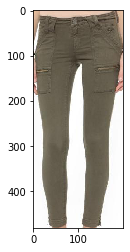

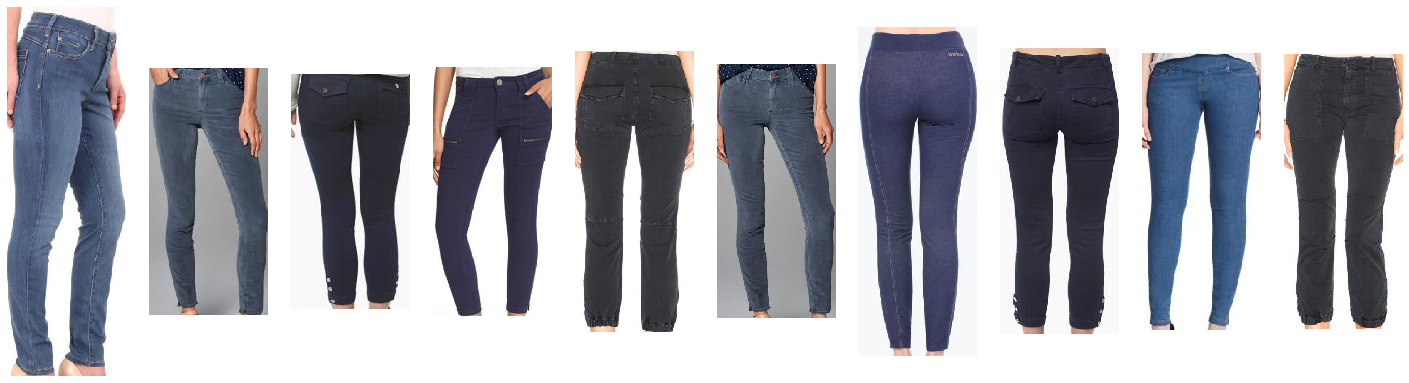

In [180]:
show_source(path,0),show_result_all(get_result(nn1[0]))

Product Attributes:    black wide leg trousers
Query:    change black to multicolor


(None, None)

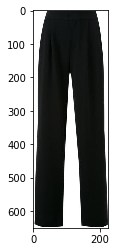

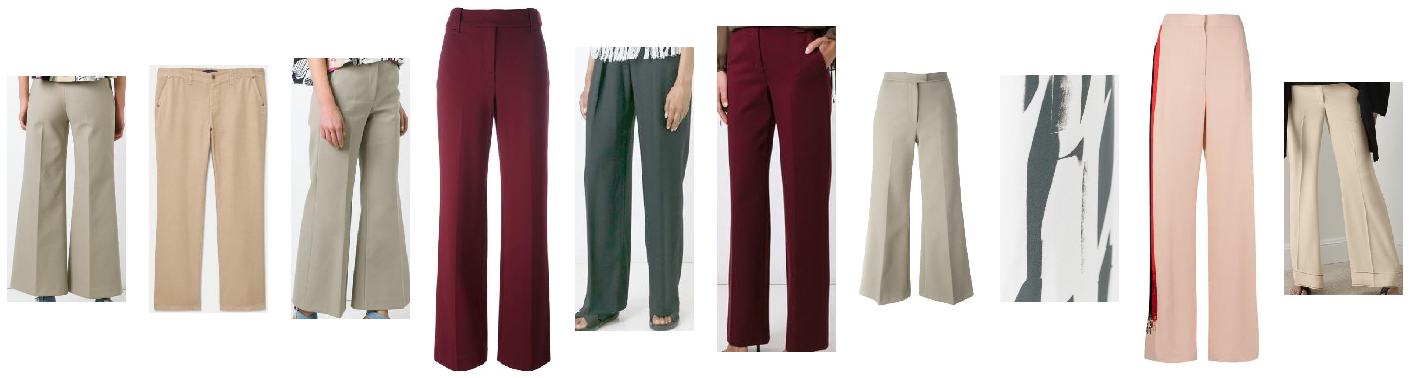

In [181]:
show_source(path,10),show_result_all(get_result(nn1[10]))

Product Attributes:    multicolor cargo harem pants
Query:    change multicolor to green


(None, None)

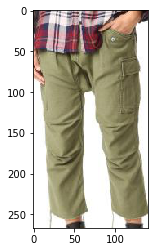

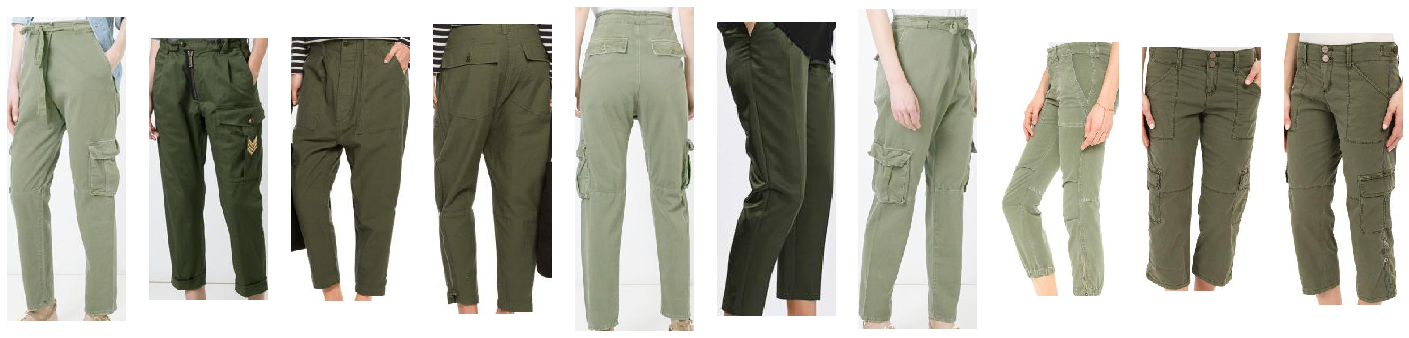

In [182]:
show_source(path,400),show_result_all(get_result(nn1[400]))

In [ ]:
from numpy import savetxt
savetxt('nn1.csv',nn1,delimiter=',')



with open('nn_results.txt', 'w') as f:
    for item in nn:
        f.write("%s\n" % item)
f.close()